some prereading: 

[Approaching (Almost) Any Machine Learning Problem](http://blog.kaggle.com/2016/07/21/approaching-almost-any-machine-learning-problem-abhishek-thakur/)


# Step 1 - get data

In [46]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# matplotlib taskbar for images
%matplotlib notebook
# https://stackoverflow.com/a/50970152
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader.data import DataReader

In [47]:
# define timeframe of stocks we retreive 
end = dt.datetime.now() 
start = end - dt.timedelta(days=5*365)

In [48]:
# use DataReader to get data from IEX https://iextrading.com/developer/
df = DataReader('MU','iex', start, end)

5y


In [49]:
# format date
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

# Step 2 - implement 2 features and visualize the price and the features in the same graph

In [50]:
import warnings
from stockstats import StockDataFrame as Sdf
warnings.filterwarnings("ignore")

# let's create some indicators
stock_df = Sdf.retype(df)

# RSI: relative strength index, 14 days
df['rsi'] = stock_df['rsi_14']
# CCI: commodity channel index, default to 14 days
df['cci'] = stock_df['cci']
# stochastic oscillator k, 14 days
df['%k'] = stock_df['kdjk_14']
# three days KDJK cross up 3 days KDJD
df['%d'] = stock_df['kdjd_14']

In [51]:
# reset index
df.reset_index(inplace=True)

In [52]:
# let's implement stochastic oscillators manually
# %K = (Current Closing Price - Lowest Low Price)/(Highest High Price - Lowest Low Price) * 100
# %D = 3-day Simple Moving Average of %K
# lowest Low = Lowest low for the last 14 periods 
# highest High = Highest high for the last 14 periods 

df['lowest14'] = df['low'].rolling(window=14).min()
df['highest14'] = df['high'].rolling(window=14).max()

df['stochasticK'] = 100*((df['close'] - df['lowest14']) / (df['highest14'] - df['lowest14']) )
df['stochasticD'] = df['stochasticK'].rolling(window=3).mean()

# let's implement ROC, rate of change, manually
# most recent closing price - Closing price n periods ago) / Closing price n periods ago) x 100
def roc(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
df['roc'] = roc(df['close'], 12)

In [53]:
# create On-Balance Volume indicator for the second phase 
i = 0
obv_arr = [0]
for i in range(len(df) - 1):
    if df.iloc[i + 1]['close'] - df.iloc[i]['close'] > 0:
        obv_arr.append(df.iloc[i]['volume'])
    elif df.iloc[i + 1]['close'] - df.iloc[i]['close'] < 0:
        obv_arr.append(-df.iloc[i + 1]['volume'])
    else:
        obv_arr.append(0)
obv = pd.Series(obv_arr)
obv_ma = pd.Series(obv.rolling(5, min_periods=1).mean(), name='obv')
df['obv'] = obv_ma

In [54]:
# create Moving Average indicator for the second phase
df['MA5'] = df["close"].rolling(window=5).mean()

### For the prediction, after some tests we ended up choosing RSI and CCI from table 1 and OBV + MA5 form table 2

In [55]:
df = df[['date', 'close', 'rsi', 'cci', 'obv', 'MA5']]

In [56]:
df.head()

,date,close,rsi,cci,obv,MA5
0,2013-10-15,16.920,NaN,NaN,0.00,NaN
1,2013-10-16,16.960,100.000000,-66.666667,31521948.50,NaN
2,2013-10-17,17.145,100.000000,-100.000000,37380084.00,NaN
3,2013-10-18,17.029,64.005953,89.655172,19292412.75,NaN
4,2013-10-21,16.565,25.095327,-166.666667,6456684.20,16.9238


<IPython.core.display.Javascript object>


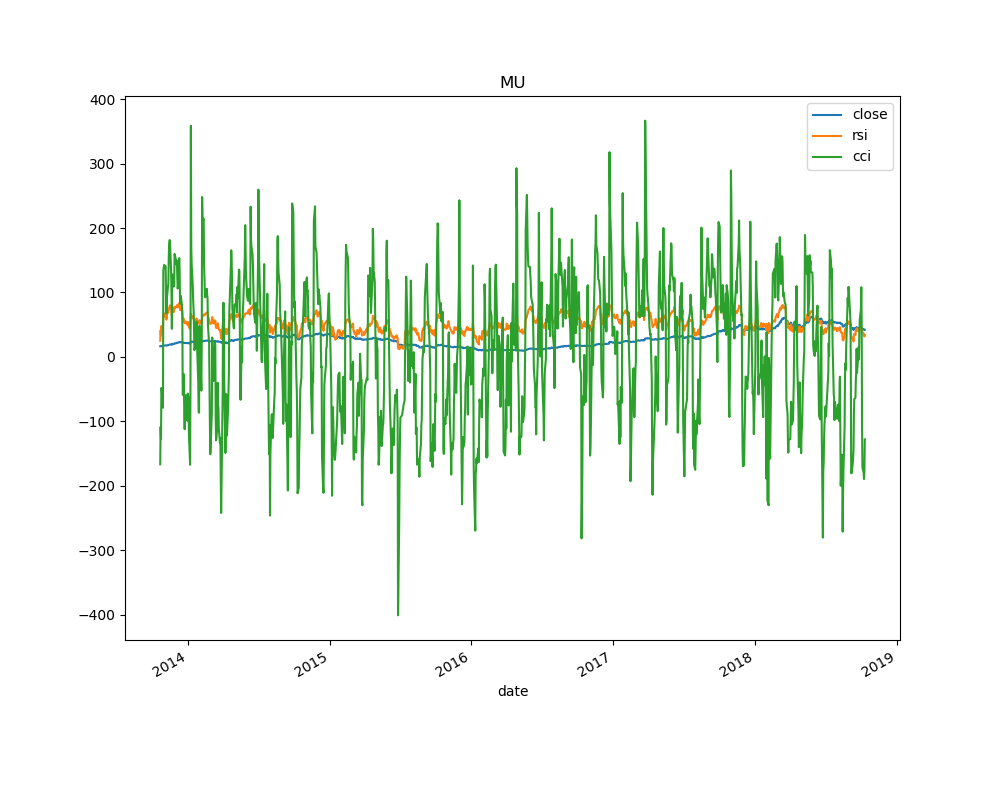

In [97]:
# plot the chosen features
# include date as index 
df[['close', 'rsi', 'cci']].set_index(df['date']).plot(figsize=(10,8), title='MU')

# Step 3 - do a regression based on the features, forecast 1-day ahead

### Based on the nature of our problem, sample size and features, we use ElasticnetCV.
### For this, we consulted the scikit cheat sheet at http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [98]:
df.head()

,date,close,rsi,cci,obv,MA5,prediction
4,2013-10-21,16.565,25.095327,-166.666667,6456684.2,16.9238,16.760
5,2013-10-22,16.760,41.257554,-108.594918,15433930.2,16.8918,16.551
6,2013-10-23,16.551,33.031115,-127.121295,-5025268.8,16.8100,16.830
7,2013-10-24,16.830,47.950944,-48.350398,-6994120.2,16.7470,16.580
8,2013-10-25,16.580,39.466235,-50.529606,-5735669.2,16.6572,16.720


In [63]:
from sklearn import preprocessing

# create label 1 day ahead
df['prediction'] = df["close"].shift(-1) #  label column with data shifted 1 unit up

# drop the few nan rows
df.dropna(axis=0, inplace=True)

# assign features we want for the regression to X
X = np.array(df[['close', 'rsi', 'cci']])

# assign label values to y
y = np.array(df['prediction'])

In [64]:
# Training time!
from sklearn.model_selection import TimeSeriesSplit
from sklearn import model_selection
from sklearn.linear_model import ElasticNetCV

# split training and test sets
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
# scale X
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) 

# train!!!
linear = ElasticNetCV()
linear.fit(X_train, y_train.reshape(len(y_train),))

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [65]:
# are we confident?
confidence = linear.score(X_test, y_test)
print("confidence: ", confidence)

confidence:  0.9368034017706822


In [66]:
# create prediction
predictions = linear.predict(X_test)

In [96]:
# Let's look at how a scatterplot of our result would look like!
# Note: with the matplotlib notebook I've had issues showing this image.
plt.scatter(y_test, predictions)

In [71]:
# check some error metrics
from sklearn import metrics

print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print("MSE:", metrics.mean_squared_error(y_test, predictions))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print("Residual sum of squares: %.2f"
     % np.mean((linear.predict(X_test) - y_test) ** 2))

MAE: 1.1503967132964543
MSE: 2.2593432618452134
RMSE: 1.5031111941054838
Residual sum of squares: 2.26


# Step 4 - plot (as a line) the regression and expected output, make the plot zoomable

In [72]:
# re-check the length for correct date placement
len(predictions)

209

<IPython.core.display.Javascript object>


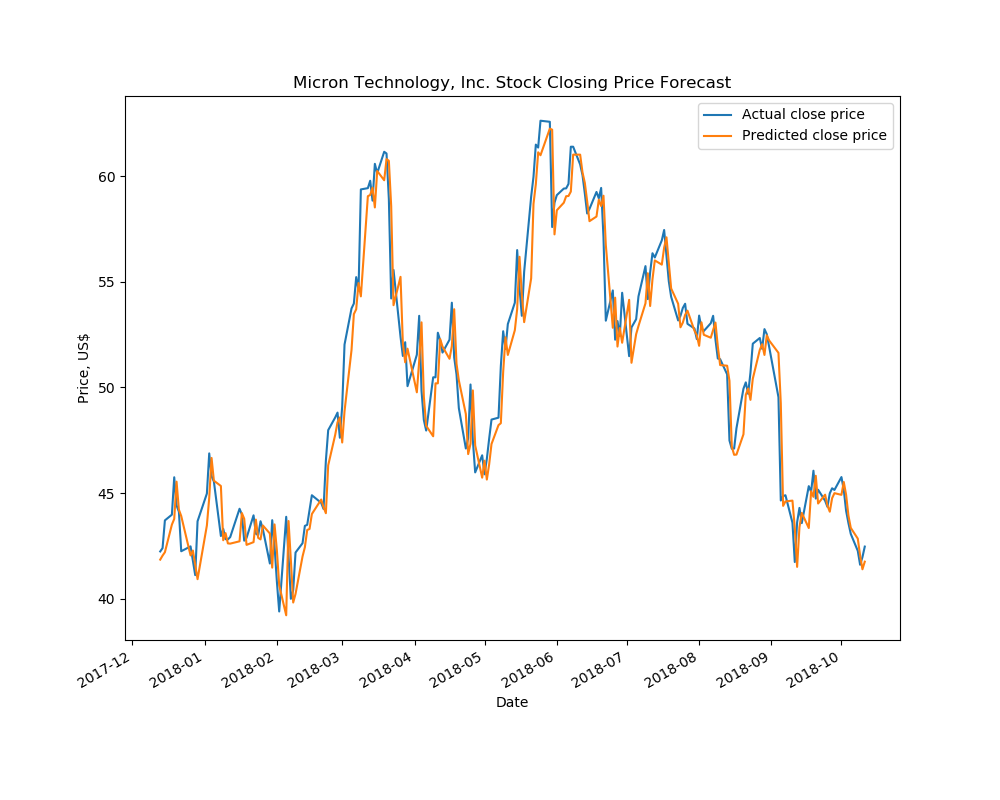

Text(0.5,0,'Date')

In [92]:
d = {'Actual close price': y_test, 'Predicted close price': predictions}
result_df = pd.DataFrame(d)
result_df.set_index(df['date'][-209:], inplace=True)
ax = result_df.plot(figsize=(10,8), title='Micron Technology, Inc. Stock Closing Price Forecast', )
ax.set_ylabel('Price, US$')
ax.set_xlabel('Date')

# Step 5 - add 2 more features from the “Type 2” category of features presented in the paper

In [75]:
df.head()

,date,close,rsi,cci,obv,MA5,prediction
4,2013-10-21,16.565,25.095327,-166.666667,6456684.2,16.9238,16.760
5,2013-10-22,16.760,41.257554,-108.594918,15433930.2,16.8918,16.551
6,2013-10-23,16.551,33.031115,-127.121295,-5025268.8,16.8100,16.830
7,2013-10-24,16.830,47.950944,-48.350398,-6994120.2,16.7470,16.580
8,2013-10-25,16.580,39.466235,-50.529606,-5735669.2,16.6572,16.720


In [76]:
# assign the features to X
X = np.array(df[['close', 'rsi', 'cci', 'obv', 'MA5']])

# assign label values to y
y = np.array(df['prediction'])

In [77]:
#split training and test sets
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
# scale X
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) 

# train!!
linear = ElasticNetCV()
linear.fit(X_train, y_train.reshape(len(y_train),))

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [78]:
# are we still confident?
confidence = linear.score(X_test, y_test)
print("confidence: ", confidence)

confidence:  0.930538116057821


In [79]:
# create prediction 2 with the 4 extracted features
predictions_2 = linear.predict(X_test)

In [80]:
# plot a scatterplot
# Note: with the matplotlib notebook I've had issues showing this image.
plt.scatter(y_test, predictions_2)

In [81]:
# Let's look at some error metrics again
print("MAE:", metrics.mean_absolute_error(y_test, predictions_2))
print("MSE:", metrics.mean_squared_error(y_test, predictions_2))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, predictions_2)))
print("Residual sum of squares: %.2f"
     % np.mean((linear.predict(X_test) - y_test) ** 2))

MAE: 1.2016512375439756
MSE: 2.483333657776384
RMSE: 1.5758596567513188
Residual sum of squares: 2.48


<IPython.core.display.Javascript object>


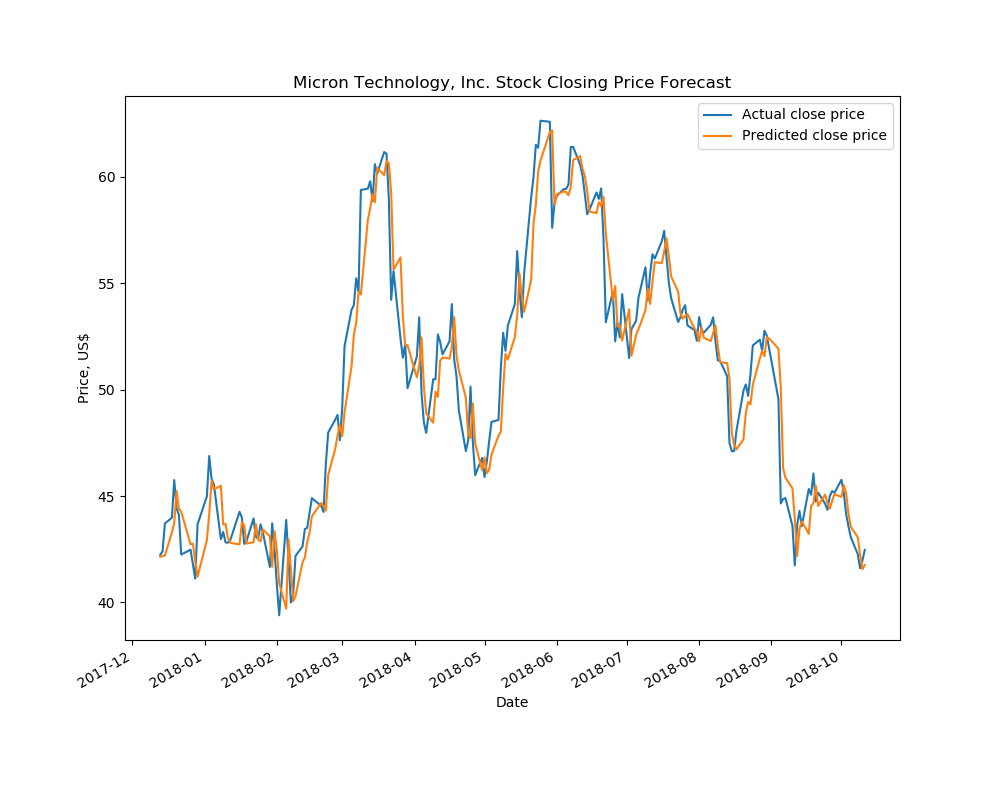

Text(0.5,0,'Date')

In [83]:
d = {'Actual close price': y_test, 'Predicted close price': predictions_2}
result_df = pd.DataFrame(d)
result_df.set_index(df['date'][-209:], inplace=True)
ax = result_df.plot(figsize=(1,8), title='Micron Technology, Inc. Stock Closing Price Forecast', )
ax.set_ylabel('Price, US$')
ax.set_xlabel('Date')

# Step 6 - design a decision for when to invest and when to sell based on your regression. 
## The model can be naïve, meaning you can create a rule (if .. X .. then .. Y)

In [84]:
# Let's create two new columns that tell us whether the actual + predicted price went upwards or downwards since previous day
result_df['Up actual'] = result_df['Actual close price'] > result_df['Actual close price'].shift(1)
result_df['Up predicted'] = result_df['Predicted close price'] > result_df['Predicted close price'].shift(1)

In [85]:
# Create a very crude decision no one would really use, as a buy/sell column based on price direction information 
# column we created above.
# We have to settle for 2-way decision, as it's very unclear at this point how to create a sensible "Hold" decision based on the 
# predicted closing price for next day.
result_df['Buy/sell actual'] = result_df['Up actual'].apply(lambda x: 'Buy' if x else 'Sell')
result_df['Buy/sell predicted'] = result_df['Up predicted'].apply(lambda x: 'Buy' if x else 'Sell')

In [86]:
# create Hit column
result_df['Hit'] = result_df['Buy/sell actual'] == result_df['Buy/sell predicted']

In [87]:
hit_rate = sum(result_df['Hit']) / len(result_df['Hit'])
print("Hit rate: %.2f" % hit_rate)

Hit rate: 0.49


In [88]:
# Create confusion matrix 

from pandas_ml import ConfusionMatrix

actual = result_df['Up actual']
predicted = result_df['Up predicted']
cm = ConfusionMatrix(actual, predicted)
cm

Predicted  False  True  __all__
Actual                         
False         50    51      101
True          55    53      108
__all__      105   104      209

In [89]:
# Let's look at some statistics about our matrix
cm.print_stats()

population: 209
P: 108
N: 101
PositiveTest: 104
NegativeTest: 105
TP: 53
TN: 50
FP: 51
FN: 55
TPR: 0.49074074074074076
TNR: 0.49504950495049505
PPV: 0.5096153846153846
NPV: 0.47619047619047616
FPR: 0.504950495049505
FDR: 0.49038461538461536
FNR: 0.5092592592592593
ACC: 0.49282296650717705
F1_score: 0.5
MCC: -0.014201944605339028
informedness: -0.014209754308764255
markedness: -0.014194139194139255
prevalence: 0.5167464114832536
LRP: 0.9718591140159768
LRN: 1.028703703703704
DOR: 0.944741532976827
FOR: 0.5238095238095238


<IPython.core.display.Javascript object>


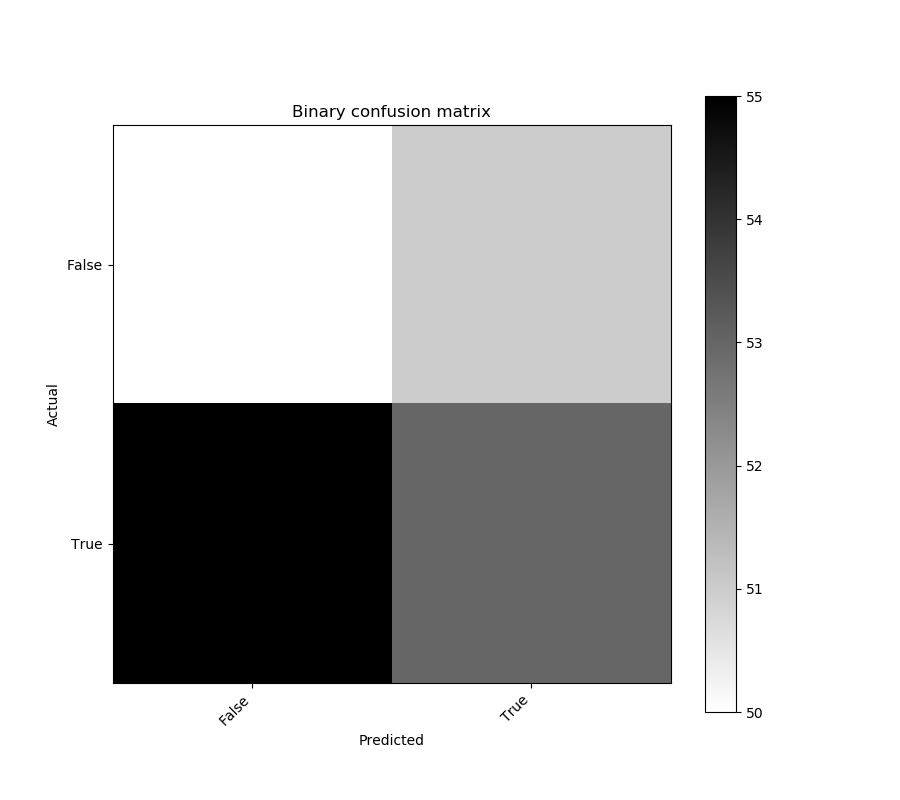

In [90]:
cm.plot()

In [91]:
result_df.head()

,Actual close price,Predicted close price,Up actual,Up predicted,Buy/sell actual,Buy/sell predicted,Hit
date,,,,,,,
2017-12-13,42.24,42.145357,False,False,Sell,Sell,True
2017-12-14,42.40,42.178695,True,True,Buy,Buy,True
2017-12-15,43.71,42.206816,True,True,Buy,Buy,True
2017-12-18,43.98,43.284185,True,True,Buy,Buy,True
2017-12-19,45.75,43.740482,True,True,Buy,Buy,True


In [37]:
# Try to count the profit/loss very simply by imagining we always trade with 1 piece of stock with the closing price, and 
# sell/buy when the prediction tells us to do so
def calculate_profit(decision, price):
    if(decision == 'Sell'):
        return price
    elif(decision == 'Buy'):
        return price * -1
    else:
        return 0
    
result_df['Profit/loss'] = result_df.apply(lambda x: calculate_profit(x['Buy/sell predicted'], x['Actual close price']), axis=1)

In [38]:
print('Profit/loss: ', sum(result_df['Profit/loss']))

Profit/loss:  -128.64000000000055


In [39]:
result_df['Profit/loss'] = result_df.apply(lambda x: calculate_profit(x['Buy/sell actual'], x['Actual close price']), axis=1)

In [40]:
print('Profit/loss: ', sum(result_df['Profit/loss']))

Profit/loss:  -495.14000000000044


# Look ma, our prediction made us lose less money! We are very good at predicting stuff!

# The end.